Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

In [ ]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
# !git clone https://github.com/DmitryUlyanov/deep-image-prior
# !mv deep-image-prior/* ./

# Import libs

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
# dtype = torch.cuda.FloatTensor
dtype = torch.float32

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [3]:
# deJPEG 
# fname = 'data/denoising/snail.jpg'

## denoising
fname = 'data/denoising/F16_GT.png'

# Load image

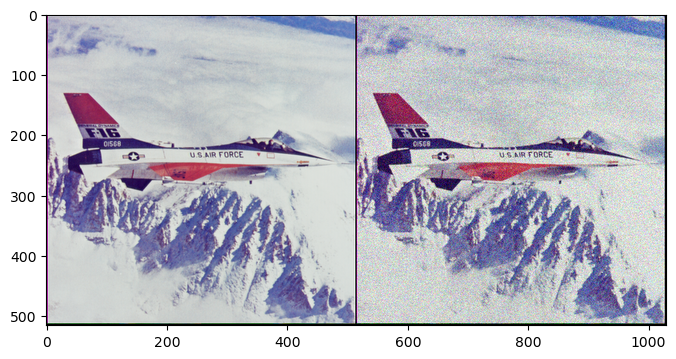

In [6]:
if fname == 'data/denoising/snail.jpg':
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)
    
    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np
    
    if PLOT:
        plot_image_grid([img_np], 4, 5);
        
elif fname == 'data/denoising/F16_GT.png':
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)
    
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
else:
    assert False

# Setup

In [9]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

if fname == 'data/denoising/snail.jpg':
    num_iter = 2400
    input_depth = 3
    figsize = 5 
    
    net = skip(
                input_depth, 3, 
                num_channels_down = [8, 16, 32, 64, 128], 
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4], 
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

    net = net.type(dtype)

elif fname == 'data/denoising/F16_GT.png':
    num_iter = 3000
    input_depth = 32 
    figsize = 4 
    
    # 这里的网络是U-Net框架的，加上了多个跳跃连接
    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128, 
                  skip_n33u=128, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

else:
    assert False
    
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Number of params: 2217831


# Optimize

In [13]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

psrn_noisy_list = []
psrn_gt_list = []
psrn_gt_sm_list = []
i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    global psrn_noisy_list, psrn_gt_list, psrn_gt_sm_list
    
    if reg_noise_std > 0:
        # 注意net_input_saved的定义，net_input_saved应该是指向net_input的，用于保留上一次net_input的结果
        # noise保留了最初的net_input
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:   # 计算平均图，out_avg在迭代过程中平稳变化
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
    # 这里计算的是网络的输出图和噪声图之间的损失，ground truth图像不是必须的
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
        
    
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), end='\n')
    psrn_noisy_list.append(psrn_noisy)
    psrn_gt_list.append(psrn_gt)
    psrn_gt_sm_list.append(psrn_gt_sm)
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1), 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        
        
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                # net_param.data.copy_(new_param.cuda())
                net_param.data.copy_(new_param.cpu())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

In [ ]:
# 训练网络（自监督学习）
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
# 如果前面已经训练好了网络，可以保存到文件F16_net中
SAVE_NET = False
if SAVE_NET:
    torch.save(net, "./data/denoising/F16_net")
    torch.save(net_input, "./data/denoising/F16_net_input")
    torch.onnx.export(net, "./data/denoising/F16_onnx") # 保存为onnx格式

# 验证

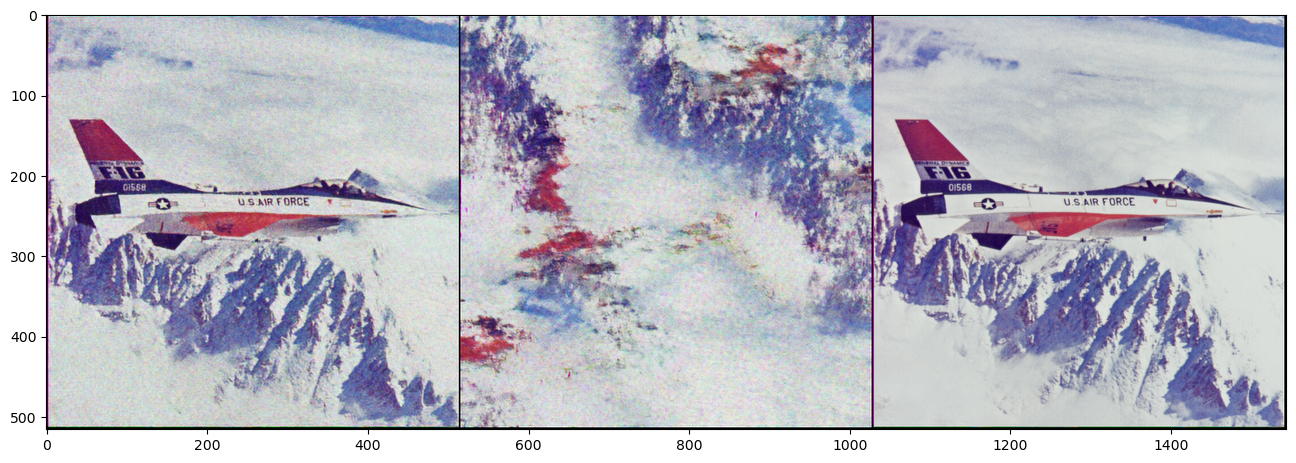

In [19]:
# 如果存在已保存的网络，可将其导出
if os.path.exists("./data/denoising/F16_net"):
    net_save = torch.load("./data/denoising/F16_net")
# 在F16的去噪任务中，输入的数据不是原始的噪声，所以需要从保存的输入数据中获取网络输入
input_data = torch.load("./data/denoising/F16_net_input")
# 随机噪声
random_noise = torch.rand(1, 32, 512, 512)

## 对比：经过网络处理后的（更新迭代后的）输入input_data 和 随机输入noise、以及 ground truth 图像
# net_input是原始噪声在训练过程中不断迭代更新后的结果，noise是原始噪声，两者输入到网络中结果是不一样的
q = plot_image_grid([torch_to_np(net_save(input_data)), torch_to_np(net_save(random_noise)), img_np], factor=13)

In [21]:
## 将训练好的网络保存起来，再用netron查看网络结构图
import netron
netron.start("./data/denoising/F16_onnx_")  # 查看网络结构

Serving './data/denoising/F16_onnx_' at http://localhost:8080


('localhost', 8080)